In [1]:
!pip install -U segmentation-models-pytorch albumentations --user
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import Dataset, DataLoader
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

Requirement already up-to-date: segmentation-models-pytorch in /home/kikos/.local/lib/python3.8/site-packages (0.2.0)
Requirement already up-to-date: albumentations in /home/kikos/.local/lib/python3.8/site-packages (1.1.0)


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import segmentation_models_pytorch as smp
import os
import pandas as pd
import random
import json
import math
from data import get_data
from tqdm import tqdm
from torchvision.io import read_image
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import torch.optim as optim
import pickle
from IPython.display import clear_output

In [4]:
data = get_data()
batch_size = 32
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [5]:
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    activation='sigmoid'
)
model = torch.load('data/22-10-14-57.pt')
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])  
loss = smp.utils.losses.JaccardLoss()
metrics = [
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.IoU(threshold=0.75),
    smp.utils.metrics.IoU(threshold=0.25)
]


train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    optimizer=optimizer,
    metrics=metrics,
    verbose=True,
)


In [6]:
from datetime import datetime

for epoch in range(2):
    print('\nEpoch: {}'.format(epoch))
    train_epoch.run(dataloader)
    clear_output(wait=True)
    if epoch % 15 == 14:
        torch.save(model, 'data/' + datetime.now().strftime('%m.%d-%H:%M:%S') + '.pt')


Epoch: 1
train: 100%|██████████| 8/8 [02:01<00:00, 15.19s/it, jaccard_loss - 0.07132, accuracy - 0.9743, iou_score - 0.931] 


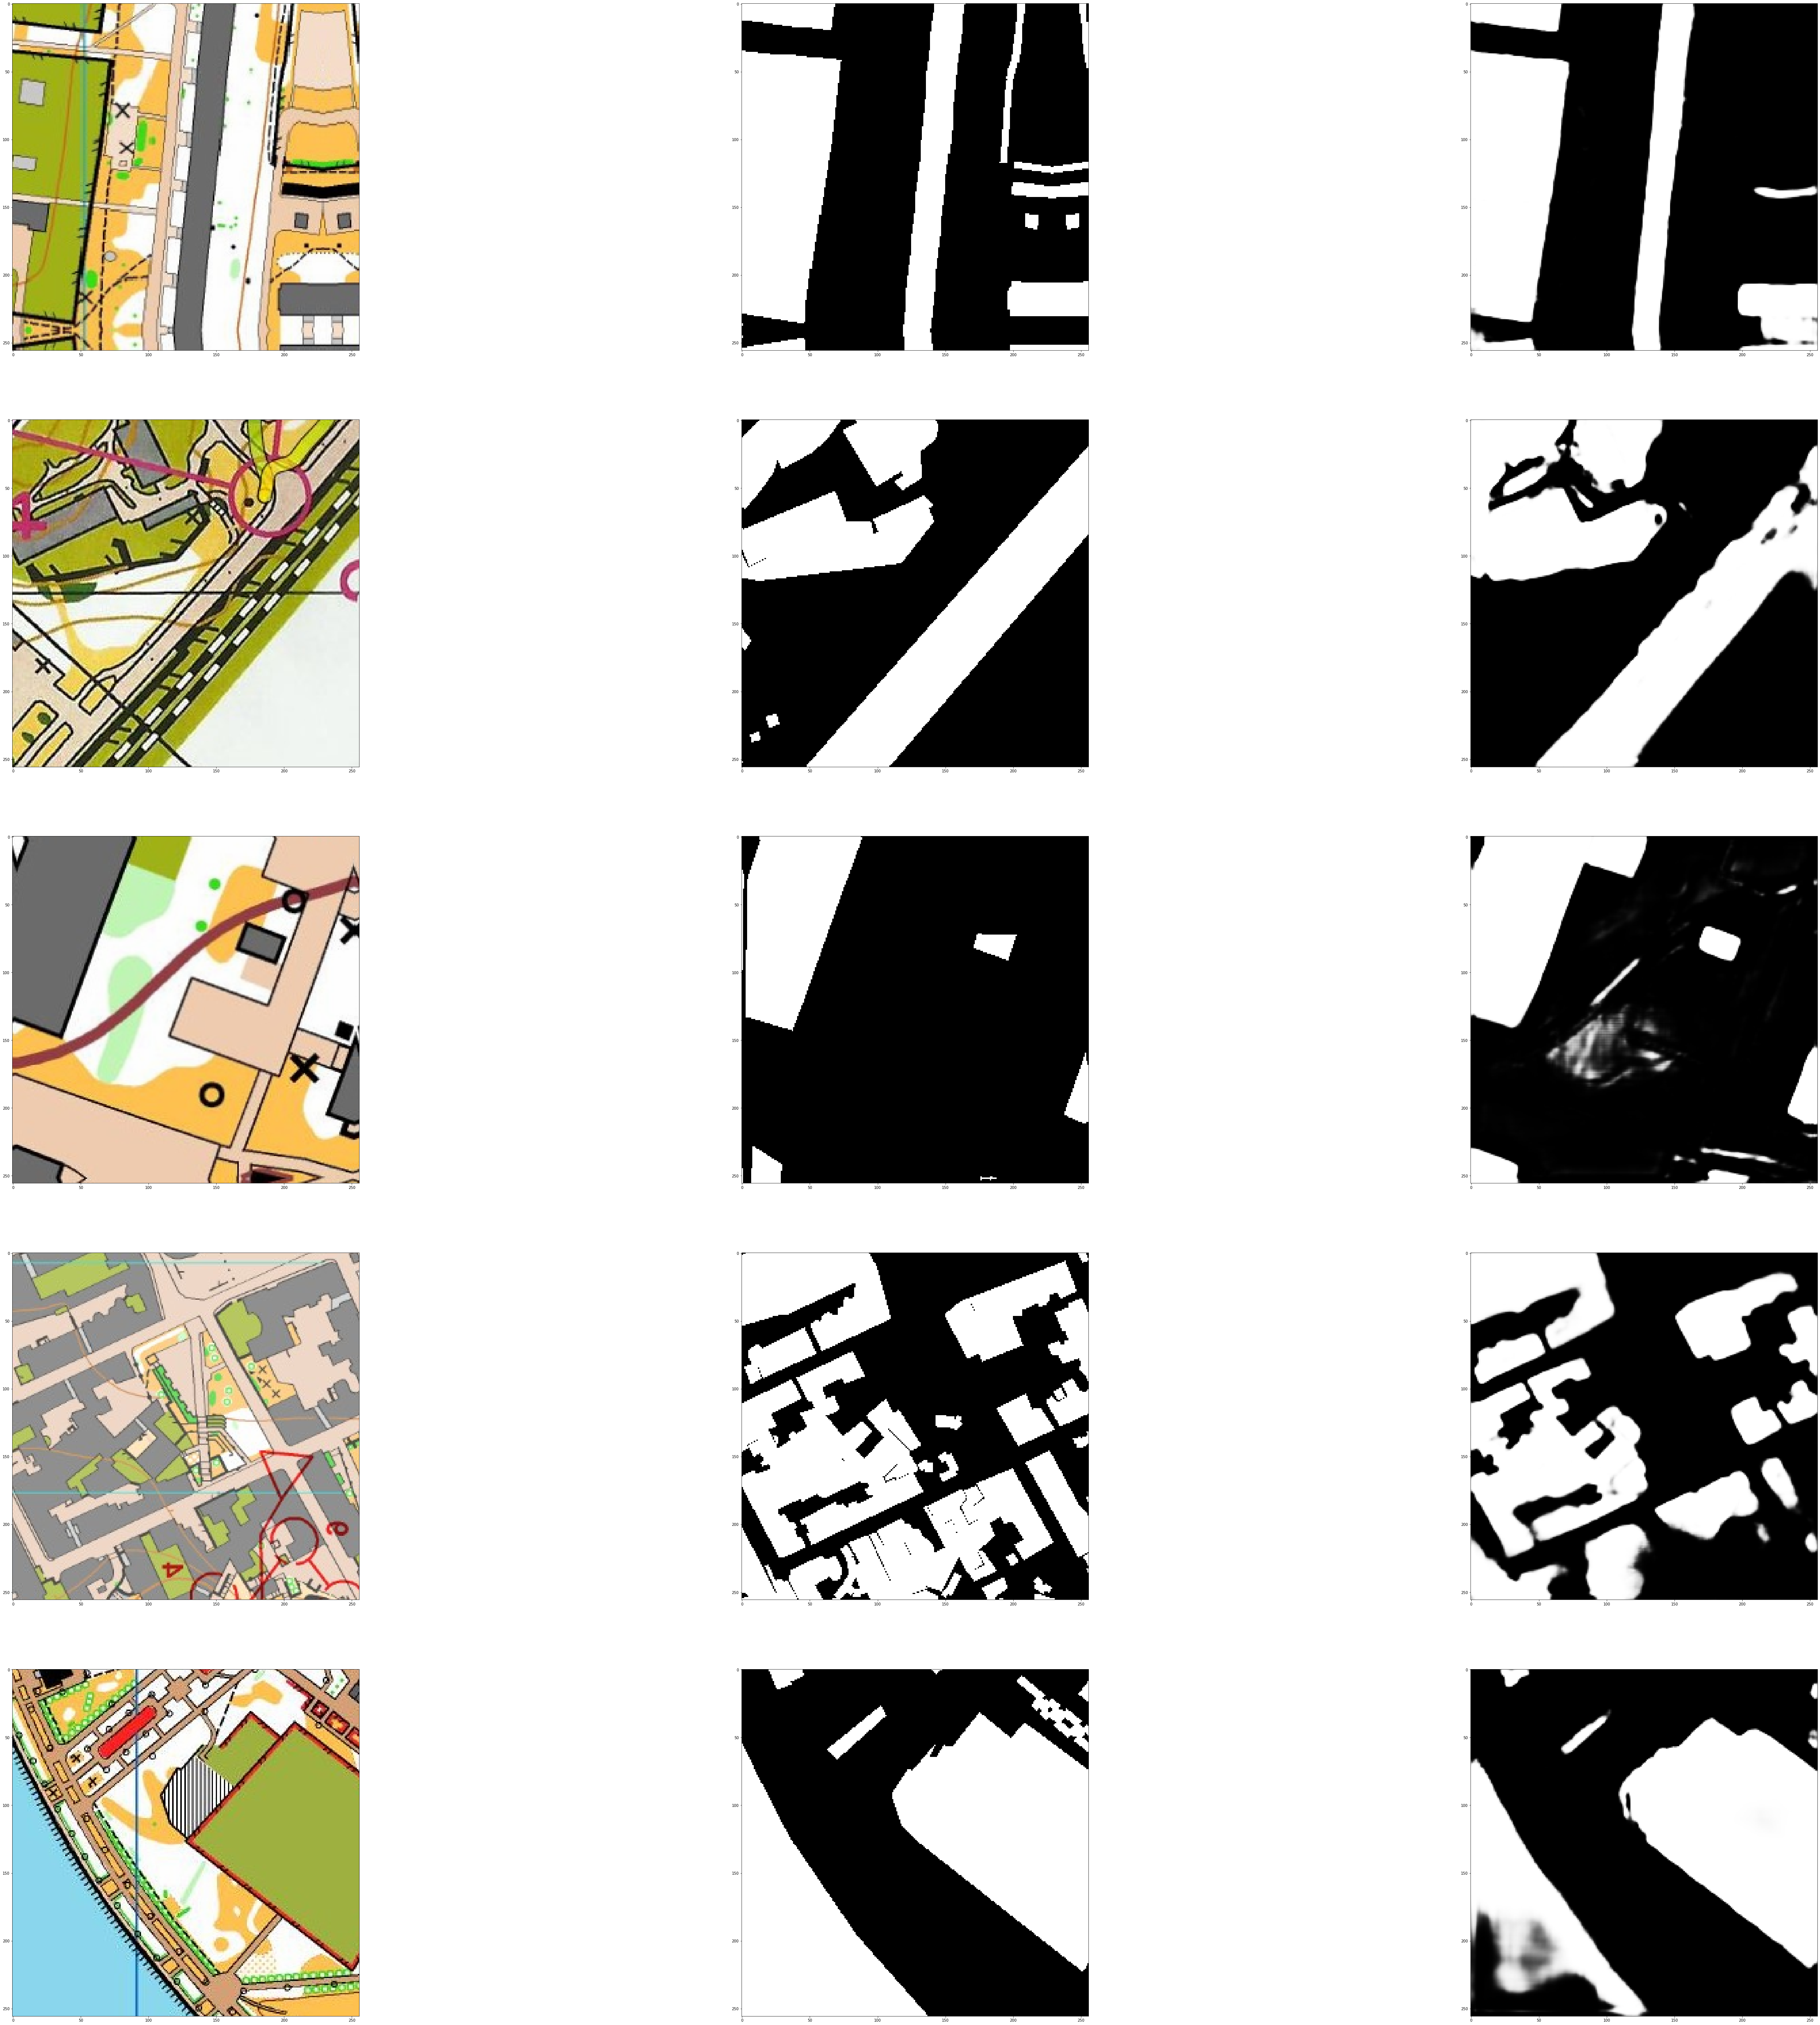

In [8]:
fig = plt.figure(figsize=(100, 100))
for i in range(5):
    X, y = data[random.randint(12345, 23456)]
    X = X.view(1, 3, 256, 256)
    pred = model(X)
    fig.add_subplot(5, 3, 3 * i + 1)
    plt.imshow(X[0].permute(1, 2, 0).detach().numpy())
    fig.add_subplot(5, 3, 3 * i + 2)
    plt.imshow(y[0], cmap='gray')
    fig.add_subplot(5, 3, 3 * i + 3)
    plt.imshow(pred[0][0].detach().numpy(), cmap='gray')
plt.show()

In [9]:
torch.save(model, 'data/22-10-17-06.pt')